In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
plt.style.use("bmh")

In [2]:

# Load and pre-process the data
df = yf.download(tickers='BTC-usd', period='max', interval='1d')
df.dropna(inplace=True)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2023-02-02,23720.824219,24167.210938,23468.595703,23471.871094,23471.871094,32066936882
2023-02-03,23469.412109,23678.103516,23279.955078,23449.322266,23449.322266,27083066007
2023-02-04,23446.320312,23556.949219,23291.794922,23331.847656,23331.847656,15639298538


In [3]:
df.drop([ 'Close'], axis=1, inplace=True)
# Datetime conversion
df['Date'] = pd.to_datetime(df.index)

# Setting the index
df.set_index('Date', inplace=True)

# Dropping any NaNs
df.dropna(inplace=True)

df.info()
df.tail(10)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3065 entries, 2014-09-17 to 2023-02-06
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3065 non-null   float64
 1   High       3065 non-null   float64
 2   Low        3065 non-null   float64
 3   Adj Close  3065 non-null   float64
 4   Volume     3065 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 143.7 KB


,Open,High,Low,Adj Close,Volume
Date,,,,,
2023-01-28,23079.964844,23165.896484,22908.845703,23031.089844,14712928379
2023-01-29,23031.449219,23919.890625,22985.070312,23774.566406,27423687259
2023-01-30,23774.648438,23789.347656,22657.582031,22840.138672,27205595568
2023-01-31,22840.796875,23225.021484,22765.568359,23139.283203,22837828665
2023-02-01,23137.835938,23764.539062,22877.750000,23723.769531,26683255504
2023-02-02,23720.824219,24167.210938,23468.595703,23471.871094,32066936882
2023-02-03,23469.412109,23678.103516,23279.955078,23449.322266,27083066007
2023-02-04,23446.320312,23556.949219,23291.794922,23331.847656,15639298538
2023-02-05,23332.248047,23423.435547,22841.759766,22955.666016,19564262605


In [4]:
# Split the data into training and test sets
train_df = df[:int(len(df)*0.8)]
test_df = df[int(len(df)*0.8):]
df.shape

(3065, 5)

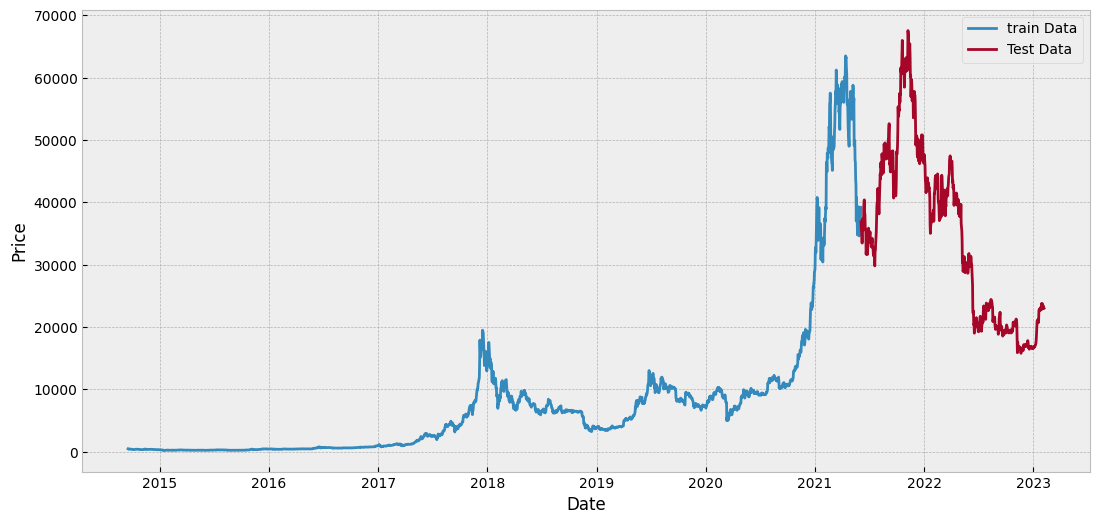

In [5]:
plt.figure(figsize=(13,6))
plt.plot(train_df['Adj Close'], label='train Data')
plt.plot(test_df['Adj Close'], label='Test Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [6]:
# Preprocess the data
X_train = train_df.drop(['Adj Close'], axis=1).values
y_train = train_df['Adj Close'].values

X_test = test_df.drop(['Adj Close'], axis=1).values
y_test = test_df['Adj Close'].values

print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

x_train (2452, 4)
y_train (2452,)
X_test (613, 4)
y_test (613,)


In [7]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
y_train = y_train.reshape(-1, 1)
y_train = scaler.fit_transform(y_train)
y_test = y_test.reshape(-1, 1)
y_test = scaler.fit_transform(y_test)
print('y_train',y_train.shape)
print('y_test', y_test.shape)

y_train (2452, 1)
y_train (613, 1)


In [ ]:
# Split the data into training and test sets
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df[0:train_size,:], df[train_size:len(df),:]
print('train_size',train_size)
print('test_size', test_size)
print("train", train.shape)
print("test", test.shape)

In [ ]:
# Convert the data into a 3D array (a sequence of sequences of timesteps)
def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(len(data) - sequence_length - 1):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

sequence_length = 1
X_train, y_train = create_sequences(train, sequence_length)
X_test, y_test = create_sequences(test, sequence_length)
print("X_train" , X_train.shape)
print("y_train", y_train.shape)
print ("x_test",X_test.shape)
print ("y_test",y_test.shape)

In [ ]:
def create_sequences1(data, sequence_length):
    X = []
    y = []
    for i in range(len(data) - sequence_length ):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

sequence_length = 1
X_train, y_train = create_sequences1(train, sequence_length)
X_test, y_test = create_sequences1(test, sequence_length)
print("X_train" , X_train.shape)
print("y_train", y_train.shape)
print ("x_test",X_test.shape)
print ("y_test",y_test.shape)


In [ ]:
# Reshape the input data for the model
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1,  X_test.shape[1]))
print("X_train", X_train.shape)
print("X_test", X_test.shape)

In [ ]:
# Build and compile the model
#model = Sequential()
#model.add(LSTM(50, input_shape=(sequence_length, 6)))
#model.add(Dense(1))
#model.compile(loss='mean_squared_error', optimizer='adam')
#model = Sequential()
#model.add(LSTM(100, input_shape=(sequence_length,X_train.shape[2]), return_sequences=True , activation= 'softmax'))
#model.add(Dropout(0.2))
#model.add(LSTM(100, activation= 'softmax'))
#model.add(Dropout(0.2))
#model.add(Dense(X_train.shape[2]))
#model.compile(loss='mean_squared_error', optimizer='adam')
#model.summary()

# Step 6: Building the Bidirectional LSTM model (cont.)
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True , activation= 'tanh'))
model.add(Dropout(0.2))
model.add(LSTM(100, activation= 'tanh'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.summary()

In [ ]:
# Train the model
history =model.fit(X_train, y_train, batch_size=32, epochs=250, validation_data=(X_test, y_test))

In [ ]:
# Evaluate the model on the test set
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:' ,score)


In [ ]:
# Evaluate the model on the test set
y_pred = model.predict(X_test)

y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

In [ ]:

# Calculate mean absolute error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

# Calculate root mean squared error (RMSE)
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

# Calculate mean absolute percentage error (MAPE)
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))


In [ ]:
# Calculate the metrics
mae_value = mae(y_test, y_pred)
rmse_value = rmse(y_test, y_pred)
mape_value = mape(y_test, y_pred)


# Print the metric values
print(f'MAE: {mae_value:.4f}')
print(f'RMSE: {rmse_value:.4f}')
print(f'MAPE: {mape_value:.4f}%')

In [ ]:
# Make sure that the number of outputs of the model match the number of outputs in y_test
print('y_pred.shape[1]',y_pred.shape[1])
print('test.shape[1]',y_test.shape[1])
assert y_pred.shape[1] == y_test.shape[1]

In [ ]:
#evaluat
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = 100 * np.mean(np.abs((y_test - y_pred) / y_test))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAPE: {:.4f}%".format(mape))
print("RMSE: {:.4f}".format(rmse))
print("MSE: {:.4f}".format(mse))
print("MAE:{:.4f}".format(mae))

In [ ]:
def smape(y_true, y_pred):
    return 200 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

SMAPE1 = smape(y_test, y_pred)
print("smape: {:.2f}%".format(SMAPE1))

In [ ]:
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history
    plt.figure(figsize=(16,5))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(16,5))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [ ]:
visualize_training_results(history)

In [ ]:
import matplotlib.pyplot as plt

# Plot the true values and predicted values
plt.plot(y_test, label='True values')
plt.plot(y_pred, label='Predicted values')

# Add a legend and show the plot
plt.legend()
plt.show()

In [ ]:

y_pred_df = pd.DataFrame(y_pred, columns=[ "Adj Close"])
y_test_df = pd.DataFrame(y_test, columns=[ "Adj Close"])

# Get the length of y_pred
y_pred_length = y_pred.shape[0]
y_test_length = y_test.shape[0]

# Generate dates for the next y_pred_length days
today = pd.Timestamp.now().date()
prediction_dates = today - timedelta(days=y_pred_length-1)
test = today - timedelta(days=y_test_length-1)
prediction = pd.date_range(start=prediction_dates, end=today, freq='D')
test_dates = pd.date_range(start=test,end=today, freq='D')

# Use the generated dates as the index of the DataFrame
y_pred_df['Date'] = prediction

y_test_df['Date'] = test_dates

# Set the index of the dataframes to be the 'Date' column
y_pred_df.set_index('Date', inplace=True)
y_test_df.set_index('Date', inplace=True)


In [ ]:
y_pred_df

In [ ]:
y_test_df

In [ ]:
plt.figure(figsize=(13,6))
plt.plot(y_pred_df['Adj Close'], label='Predictions')
plt.plot(y_test_df['Adj Close'], label='Test Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()